# Finding Groups: Clustering with K-Means

## Introduction to Unsupervised Learning

Welcome to our exploration of unsupervised learning! Unlike supervised learning where we have labeled data to guide us, unsupervised learning discovers hidden patterns and structures in data without any labels. Today, we'll focus on one of the most fundamental unsupervised learning algorithms: K-Means clustering.

Clustering is the task of grouping similar data points together. It's like organizing a messy room - you naturally group similar items together without being told exactly how to do it. K-Means is particularly powerful because of its simplicity, efficiency, and wide applicability across domains.

## Learning Objectives

By the end of this lecture, you will:

1. **Understand** the fundamental concepts of clustering and unsupervised learning
2. **Master** the K-Means algorithm, including its mathematical foundations
3. **Apply** K-Means to real-world data and interpret the results
4. **Evaluate** clustering quality using multiple metrics
5. **Recognize** the strengths and limitations of K-Means
6. **Choose** optimal parameters using data-driven approaches
7. **Compare** K-Means with its variants for different scenarios

## Part 1: Motivation - Why Clustering Matters

Clustering appears everywhere in our daily lives and across industries:

- **Retail**: Grouping customers for targeted marketing
- **Biology**: Identifying gene expression patterns
- **Finance**: Detecting fraudulent transaction patterns
- **Computer Vision**: Image segmentation and compression
- **Natural Language Processing**: Document organization
- **Manufacturing**: Quality control and defect detection

The power of clustering lies in its ability to reveal structure in data without requiring labeled examples.

## Setting Up Our Environment


In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups, make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
%matplotlib inline

print("Environment ready! Let's start clustering!")

Environment ready! Let's start clustering!


## Part 2: Quick Start - Your First K-Means Clustering

Let's begin with a simple, visual example to build intuition before diving into theory.


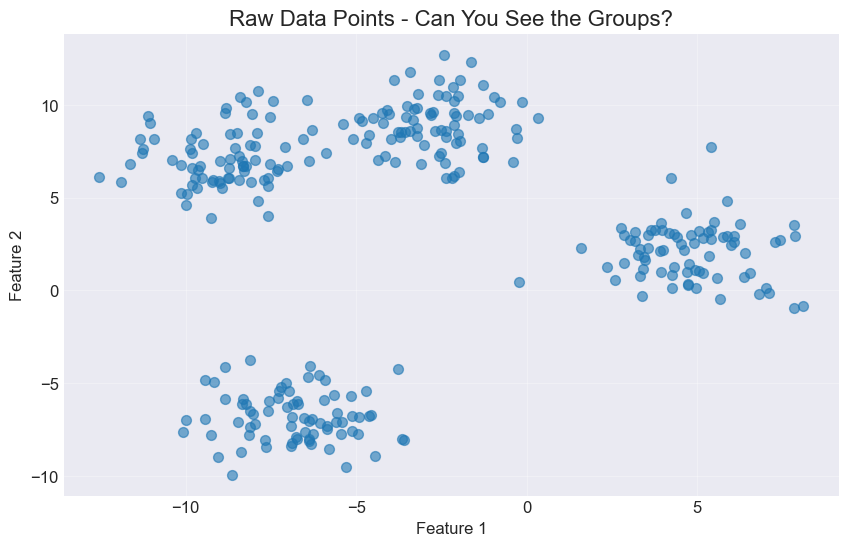

In [2]:
# Generate synthetic data with clear clusters
np.random.seed(42)
X_simple, y_true = make_blobs(n_samples=300, 
                              centers=4, 
                              n_features=2, 
                              center_box=(-10.0, 10.0),
                              cluster_std=1.5,
                              random_state=42)

# Visualize the raw data
plt.figure(figsize=(10, 6))
plt.scatter(X_simple[:, 0], X_simple[:, 1], alpha=0.6, s=50)
plt.title('Raw Data Points - Can You See the Groups?', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)
plt.show()

### Understanding the Data

The plot above shows 300 data points in 2D space. Even without any algorithm, your eyes can probably identify distinct groups or clusters. This is exactly what K-Means will do automatically - find these natural groupings in the data.

Notice how some points clearly belong together while others are more isolated. K-Means will assign every single point to exactly one cluster, even those that might be on the boundaries between groups.

## Your First K-Means Model

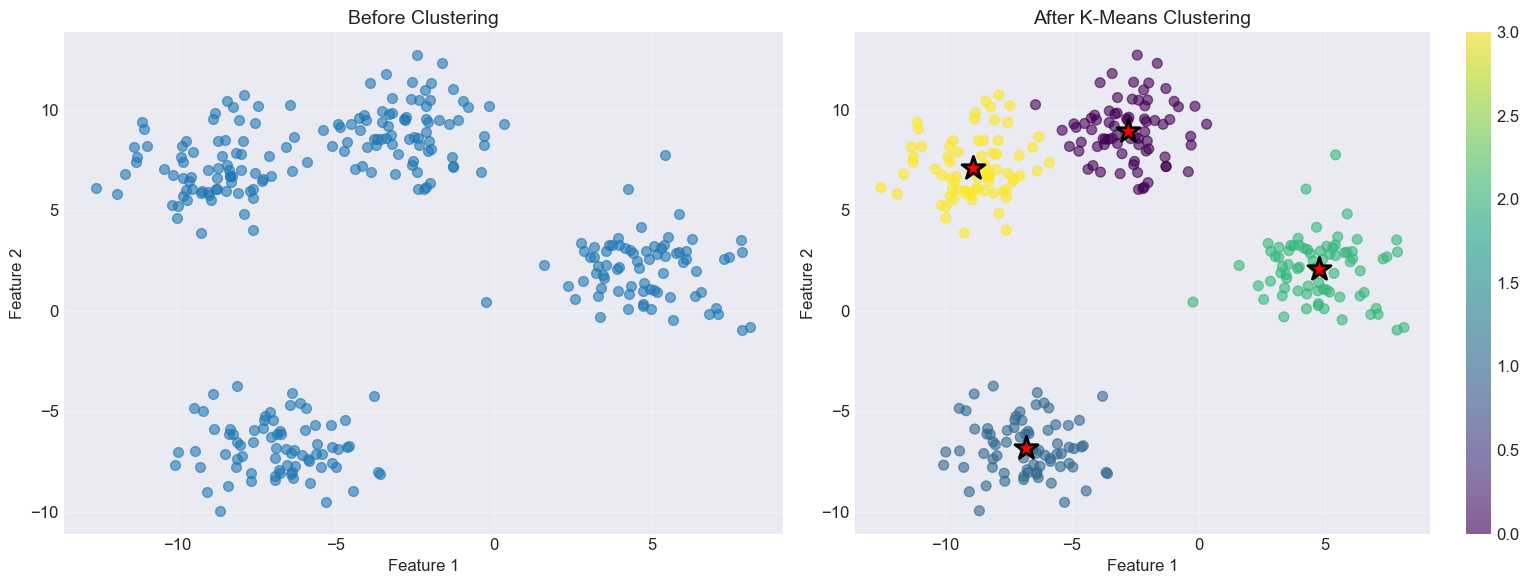

In [3]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_simple)

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original data
ax1.scatter(X_simple[:, 0], X_simple[:, 1], alpha=0.6, s=50)
ax1.set_title('Before Clustering', fontsize=14)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.grid(True, alpha=0.3)

# Clustered data
scatter = ax2.scatter(X_simple[:, 0], X_simple[:, 1], 
                     c=cluster_labels, cmap='viridis', 
                     alpha=0.6, s=50)
ax2.scatter(kmeans.cluster_centers_[:, 0], 
           kmeans.cluster_centers_[:, 1], 
           c='red', marker='*', s=300, 
           edgecolors='black', linewidth=2)
ax2.set_title('After K-Means Clustering', fontsize=14)
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2)

plt.tight_layout()
plt.show()

### What Just Happened?

The K-Means algorithm successfully identified 4 distinct clusters in our data:
- Each color represents a different cluster
- The red stars show the cluster centers (centroids)
- Every point is assigned to exactly one cluster
- Points are assigned to the cluster whose center is nearest

The algorithm found these groups without any labels or supervision - it discovered the structure purely from the data patterns!

## Part 3: Real-World Example - Document Clustering

Now let's tackle a more challenging problem: organizing text documents. We'll use the 20 Newsgroups dataset, a collection of approximately 20,000 newsgroup posts across 20 different topics.


In [4]:
# Load a subset of newsgroups data
categories = ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'talk.politics.mideast']
newsgroups = fetch_20newsgroups(subset='train', 
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'),
                               random_state=42)

print(f"Dataset loaded successfully!")
print(f"Number of documents: {len(newsgroups.data)}")
print(f"Categories: {categories}")
print(f"\nSample document (first 500 characters):")
print("-" * 60)
print(newsgroups.data[0][:500] + "...")

Dataset loaded successfully!
Number of documents: 2339
Categories: ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'talk.politics.mideast']

Sample document (first 500 characters):
------------------------------------------------------------



The term arrhythmia is usually used to encompass a wide range of abnormal
heart rhythms (cardiac dysrhythmias).  Some of them are very serious
while others are completely benign.  Having "a few irregular beats"
on an EKG could be serious depending on what those beats were and
when they occurred, or could be of no significance.

Low blood potassium levels probably predispose people with underlying
heart disease to develop arrhythmias.  Very low potassium levels are
clearly dangerous, but it is...


### Understanding Text Data Challenges

Text data presents unique challenges for clustering:
1. **High dimensionality**: Thousands of unique words
2. **Sparsity**: Most documents contain only a fraction of all words
3. **Varying length**: Documents can be very short or very long
4. **Semantic meaning**: "car" and "automobile" mean the same thing

We need to convert this text into numerical form that K-Means can understand.


## Converting Text to Numbers: TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects how important a word is to a document within a collection of documents.

### The Mathematics of TF-IDF

For a term $t$ in document $d$ from a collection of documents $D$:

**Term Frequency (TF):**
$$\text{TF}(t,d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}$$

**Inverse Document Frequency (IDF):**
$$\text{IDF}(t,D) = \log\left(\frac{\text{Total number of documents}}{|\{d \in D : t \in d\}|}\right)$$

**TF-IDF Score:**
$$\text{TF-IDF}(t,d,D) = \text{TF}(t,d) \times \text{IDF}(t,D)$$



## Implementing TF-IDF Transformation

In [5]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=2000,      # Use top 2000 words
    stop_words='english',   # Remove common words like 'the', 'is'
    max_df=0.5,            # Ignore terms appearing in >50% of documents
    min_df=5,              # Ignore terms appearing in <5 documents
    ngram_range=(1, 2)     # Include both single words and bigrams
)

X_tfidf = vectorizer.fit_transform(newsgroups.data)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"This represents {X_tfidf.shape[0]} documents with {X_tfidf.shape[1]} features")
print(f"Matrix sparsity: {100 * (1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])):.2f}%")

# Examine some important terms
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features (terms):")
print(feature_names[100:110])

TF-IDF matrix shape: (2339, 2000)
This represents 2339 documents with 2000 features
Matrix sparsity: 98.10%

Sample features (terms):
['ac uk' 'accept' 'accepted' 'access' 'according' 'account' 'acid' 'act'
 'action' 'actions']


### Understanding the TF-IDF Output

The TF-IDF transformation has converted our text documents into a sparse matrix where:
- Each row represents a document
- Each column represents a term (word or bigram)
- Each value represents the TF-IDF score of that term in that document

The high sparsity (typically >95%) shows that most documents use only a small fraction of the total vocabulary. This is normal and expected for text data.

## Part 4: The K-Means Algorithm - Mathematical Foundation

### The Objective Function

K-Means aims to minimize the within-cluster sum of squares (WCSS), also called inertia:

$$J = \sum_{i=1}^{n} \sum_{j=1}^{k} w_{ij} ||x_i - \mu_j||^2$$

Where:
- $n$ = number of data points
- $k$ = number of clusters
- $w_{ij} = 1$ if $x_i$ belongs to cluster $j$, 0 otherwise
- $x_i$ = the $i$-th data point
- $\mu_j$ = the centroid of cluster $j$
- $||x_i - \mu_j||^2$ = squared Euclidean distance


## The K-Means Algorithm Steps

The algorithm iteratively performs two steps until convergence:

### Step 1: Assignment Step
Assign each data point to the nearest centroid:
$$C_i = \arg\min_{j \in \{1,...,k\}} ||x_i - \mu_j||^2$$

### Step 2: Update Step
Recalculate centroids as the mean of assigned points:
$$\mu_j = \frac{1}{|S_j|} \sum_{x_i \in S_j} x_i$$

Where $S_j$ is the set of points assigned to cluster $j$.

## Implementing K-Means from Scratch

Let's implement the algorithm to truly understand how it works:

In [6]:
def kmeans_from_scratch(X, k, max_iters=100, tol=1e-4):
    """
    Implement K-Means clustering from scratch
    
    Parameters:
    X: data matrix (n_samples, n_features)
    k: number of clusters
    max_iters: maximum iterations
    tol: convergence tolerance
    """
    n_samples, n_features = X.shape
    
    # Step 1: Initialize centroids randomly
    idx = np.random.choice(n_samples, k, replace=False)
    centroids = X[idx].copy()
    
    # Store history for visualization
    history = {'centroids': [centroids.copy()], 'labels': []}
    
    for iteration in range(max_iters):
        # Assignment step: assign points to nearest centroid
        distances = np.zeros((n_samples, k))
        for j in range(k):
            distances[:, j] = np.sum((X - centroids[j])**2, axis=1)
        labels = np.argmin(distances, axis=1)
        history['labels'].append(labels.copy())
        
        # Update step: compute new centroids
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centroids[j] = cluster_points.mean(axis=0)
            else:
                new_centroids[j] = centroids[j]  # Keep old centroid if cluster is empty
        
        # Check convergence
        if np.sum((new_centroids - centroids)**2) < tol:
            print(f"Converged after {iteration + 1} iterations")
            break
            
        centroids = new_centroids.copy()
        history['centroids'].append(centroids.copy())
    
    return labels, centroids, history

## Visualizing K-Means Convergence

Converged after 4 iterations


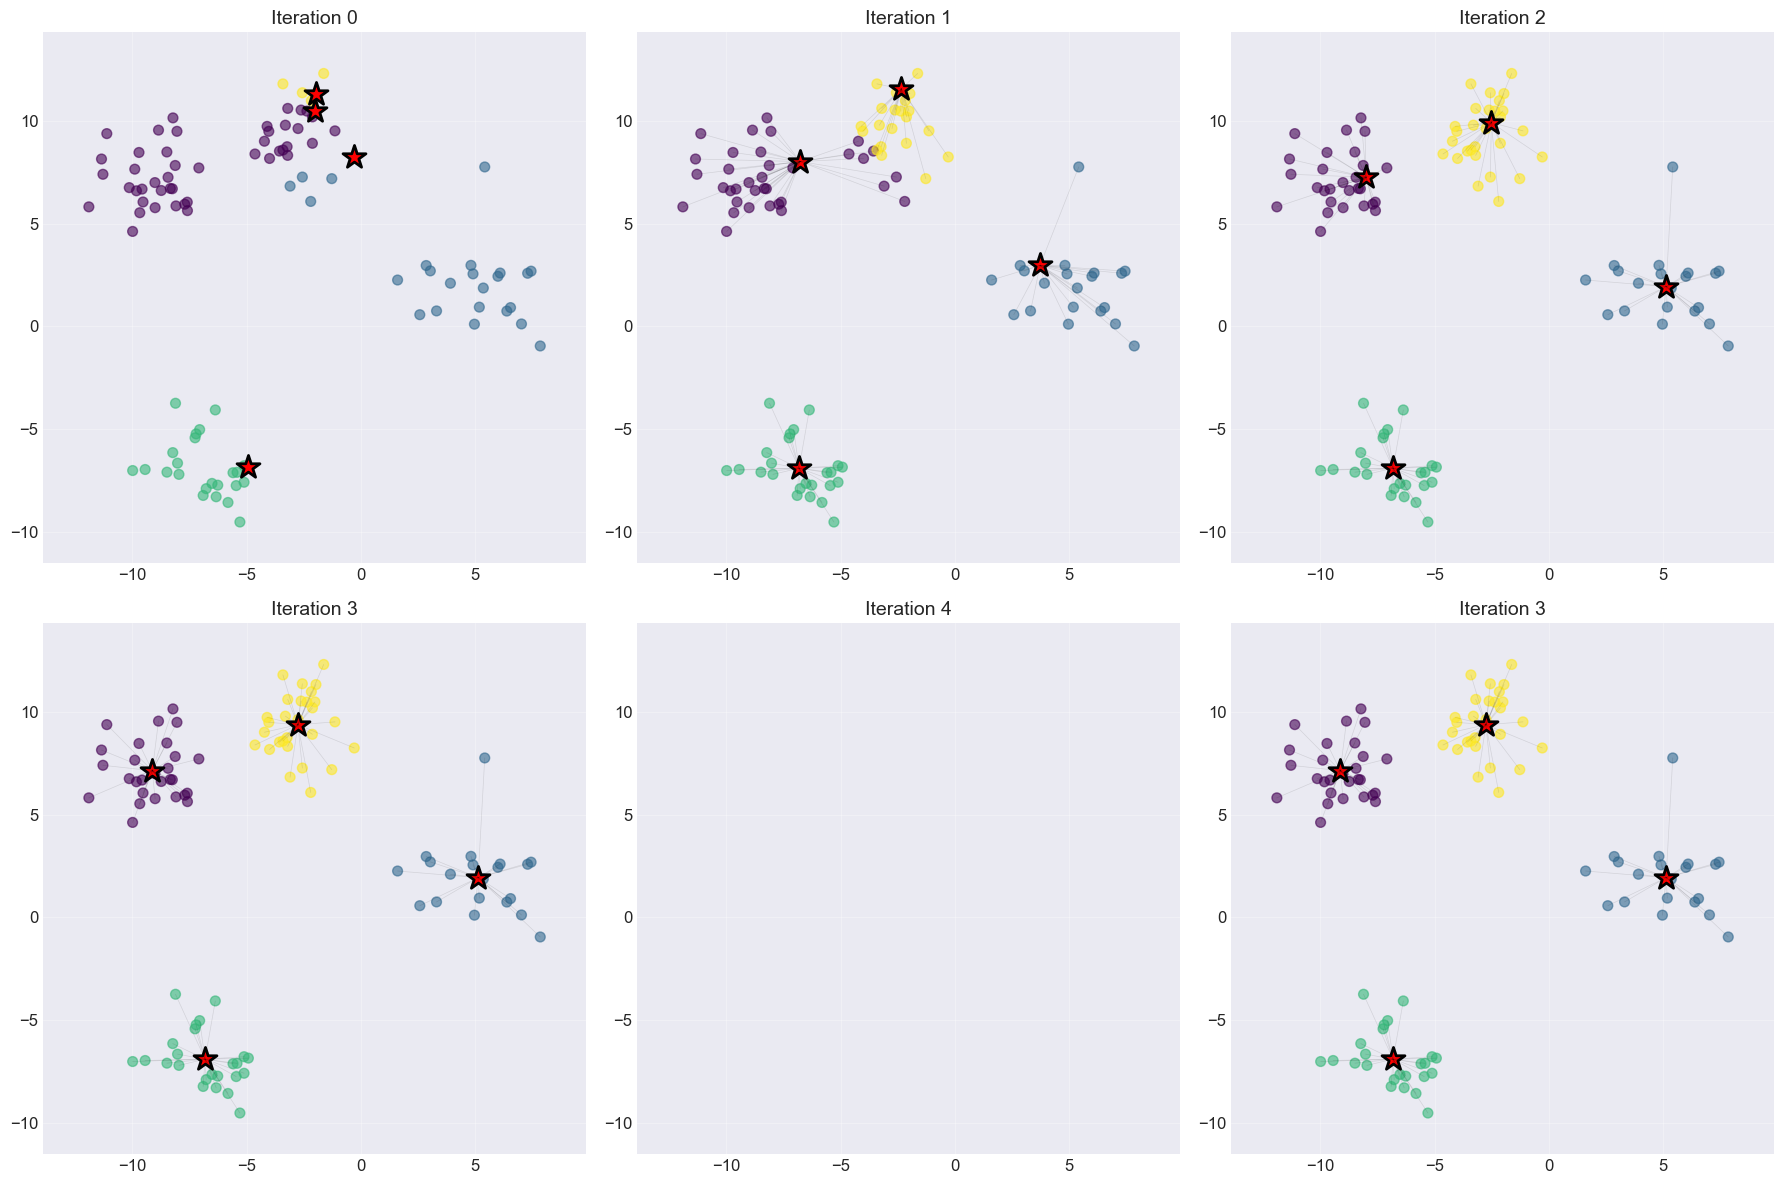

In [7]:
# Run our implementation on simple 2D data
X_demo = X_simple[:100]  # Use subset for clarity
labels_scratch, centroids_scratch, history = kmeans_from_scratch(X_demo, k=4, max_iters=10)

# Visualize the convergence process
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

iterations_to_show = [0, 1, 2, 3, 4, len(history['labels'])-1]

for idx, iter_num in enumerate(iterations_to_show):
    ax = axes[idx]
    
    if iter_num < len(history['labels']):
        labels = history['labels'][iter_num]
        centroids = history['centroids'][iter_num]
        
        # Plot points
        scatter = ax.scatter(X_demo[:, 0], X_demo[:, 1], 
                           c=labels, cmap='viridis', alpha=0.6, s=50)
        
        # Plot centroids
        ax.scatter(centroids[:, 0], centroids[:, 1], 
                  c='red', marker='*', s=300, 
                  edgecolors='black', linewidth=2)
        
        # Draw lines from points to centroids
        if iter_num > 0:
            for i in range(len(X_demo)):
                ax.plot([X_demo[i, 0], centroids[labels[i], 0]], 
                       [X_demo[i, 1], centroids[labels[i], 1]], 
                       'k-', alpha=0.1, linewidth=0.5)
    
    ax.set_title(f'Iteration {iter_num}', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(X_demo[:, 0].min() - 2, X_demo[:, 0].max() + 2)
    ax.set_ylim(X_demo[:, 1].min() - 2, X_demo[:, 1].max() + 2)

plt.tight_layout()
plt.show()

### Understanding the Convergence Process

The visualization shows how K-Means iteratively refines the clusters:

1. **Iteration 0**: Random initialization of centroids
2. **Iterations 1-2**: Large movements as centroids find their clusters
3. **Iterations 3-4**: Smaller adjustments as algorithm fine-tunes
4. **Final iteration**: Convergence achieved - centroids stabilize

The thin lines show the assignment of points to centroids. Notice how the algorithm quickly identifies the natural structure in the data.

## Applying K-Means to Text Data

In [8]:
# Apply K-Means to our document collection
k = 4  # We know there are 4 categories
kmeans_text = KMeans(n_clusters=k, 
                     init='k-means++',  # Smart initialization
                     n_init=10,         # Run 10 times with different seeds
                     max_iter=300,      # Maximum iterations
                     random_state=42)

document_clusters = kmeans_text.fit_predict(X_tfidf)

# Calculate clustering metrics
inertia = kmeans_text.inertia_
silhouette = silhouette_score(X_tfidf, document_clusters, sample_size=1000)
ari = adjusted_rand_score(newsgroups.target, document_clusters)

print(f"Clustering completed!")
print(f"Inertia (WCSS): {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"\nCluster sizes:")
unique, counts = np.unique(document_clusters, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} documents")

Clustering completed!
Inertia (WCSS): 2132.56
Silhouette Score: 0.026
Adjusted Rand Index: 0.236

Cluster sizes:
  Cluster 0: 1472 documents
  Cluster 1: 71 documents
  Cluster 2: 457 documents
  Cluster 3: 339 documents


### Interpreting Clustering Metrics

- **Inertia**: Lower is better. Measures compactness of clusters
- **Silhouette Score**: Ranges from -1 to 1. Higher indicates better-defined clusters
- **Adjusted Rand Index**: Measures agreement with true labels (when available). 1.0 = perfect match, 0.0 = random clustering

Our results show moderate clustering quality, which is expected given the complexity of text data and overlapping topics.


## What Topics Did K-Means Discover?

In [9]:
def analyze_clusters(vectorizer, kmeans, n_terms=15):
    """Extract and display top terms for each cluster"""
    
    # Get feature names and cluster centers
    terms = vectorizer.get_feature_names_out()
    centers = kmeans.cluster_centers_
    
    # For each cluster, find top terms
    for i in range(kmeans.n_clusters):
        # Get indices of top terms for this cluster
        top_indices = centers[i].argsort()[-n_terms:][::-1]
        top_terms = [terms[j] for j in top_indices]
        top_scores = centers[i][top_indices]
        
        print(f"\nCluster {i} - Top Terms:")
        print("-" * 50)
        for term, score in zip(top_terms, top_scores):
            print(f"  {term:20} (score: {score:.3f})")

analyze_clusters(vectorizer, kmeans_text, n_terms=10)


Cluster 0 - Top Terms:
--------------------------------------------------
  think                (score: 0.023)
  don                  (score: 0.023)
  just                 (score: 0.023)
  year                 (score: 0.019)
  like                 (score: 0.019)
  good                 (score: 0.017)
  know                 (score: 0.017)
  time                 (score: 0.016)
  people               (score: 0.015)
  team                 (score: 0.014)

Cluster 1 - Top Terms:
--------------------------------------------------
  dsl pitt             (score: 0.153)
  geb cadre            (score: 0.153)
  cadre                (score: 0.153)
  dsl                  (score: 0.153)
  surrender soon       (score: 0.153)
  cadre dsl            (score: 0.153)
  intellect geb        (score: 0.153)
  shameful surrender   (score: 0.153)
  edu shameful         (score: 0.153)
  n3jxp                (score: 0.153)

Cluster 2 - Top Terms:
--------------------------------------------------
  thanks       


### Understanding Cluster Characteristics

Each cluster has discovered a distinct topic based on term frequencies:
- The top terms reveal the dominant theme in each cluster
- Higher scores indicate terms that are more characteristic of that cluster
- Some overlap between clusters is normal, especially for related topics

This demonstrates K-Means' ability to discover meaningful patterns without any labeled training data!


In [10]:
## Examining Sample Documents from Each Cluster

def examine_cluster_documents(cluster_id, n_samples=3):
    """
    Display sample documents from a specific cluster
    """
    # Get indices of documents in this cluster
    cluster_indices = np.where(document_clusters == cluster_id)[0]
    
    # Randomly sample documents from this cluster
    sample_indices = np.random.choice(cluster_indices, 
                                     min(n_samples, len(cluster_indices)), 
                                     replace=False)
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} - Sample Documents")
    print(f"Total documents in cluster: {len(cluster_indices)}")
    print(f"{'='*60}\n")
    
    for idx, doc_idx in enumerate(sample_indices):
        # Get the actual category
        true_category = categories[newsgroups.target[doc_idx]]
        
        print(f"Document {idx+1} (True category: {true_category}):")
        print("-" * 50)
        # Print first 400 characters
        print(newsgroups.data[doc_idx][:400] + "...")
        print("\n")

# Examine documents from each cluster
for cluster_id in range(4):
    examine_cluster_documents(cluster_id, n_samples=2)


CLUSTER 0 - Sample Documents
Total documents in cluster: 1472

Document 1 (True category: comp.graphics):
--------------------------------------------------
Concerning the proposed newsgroup split, I personally am not in favor of
doing this.  I learn an awful lot about all aspects of graphics by reading
this group, from code to hardware to algorithms.  I just think making 5
different groups out of this is a wate, and will only result in a few posts
a week per group.  I kind of like the convenience of having one big forum
for discussing all aspects of ...


Document 2 (True category: sci.med):
--------------------------------------------------
: Could somebody explain to me what a centrifuge is and what it is
: used for? I vaguely remembre it being something that spins test tubes
: around really fast but I cant remember why youd want to do that?


Purely recreational.  They get bored sitting in that
rack all the time.


...



CLUSTER 1 - Sample Documents
Total documents in cluster: 71

### Document Cluster Analysis

The document samples reveal how K-Means grouped similar content:
- Documents within each cluster share common vocabulary and topics
- Some misclassifications occur when documents use overlapping terminology
- Cluster quality depends on the distinctiveness of the topics

This examination helps validate our clustering and understand edge cases where documents might be ambiguous.

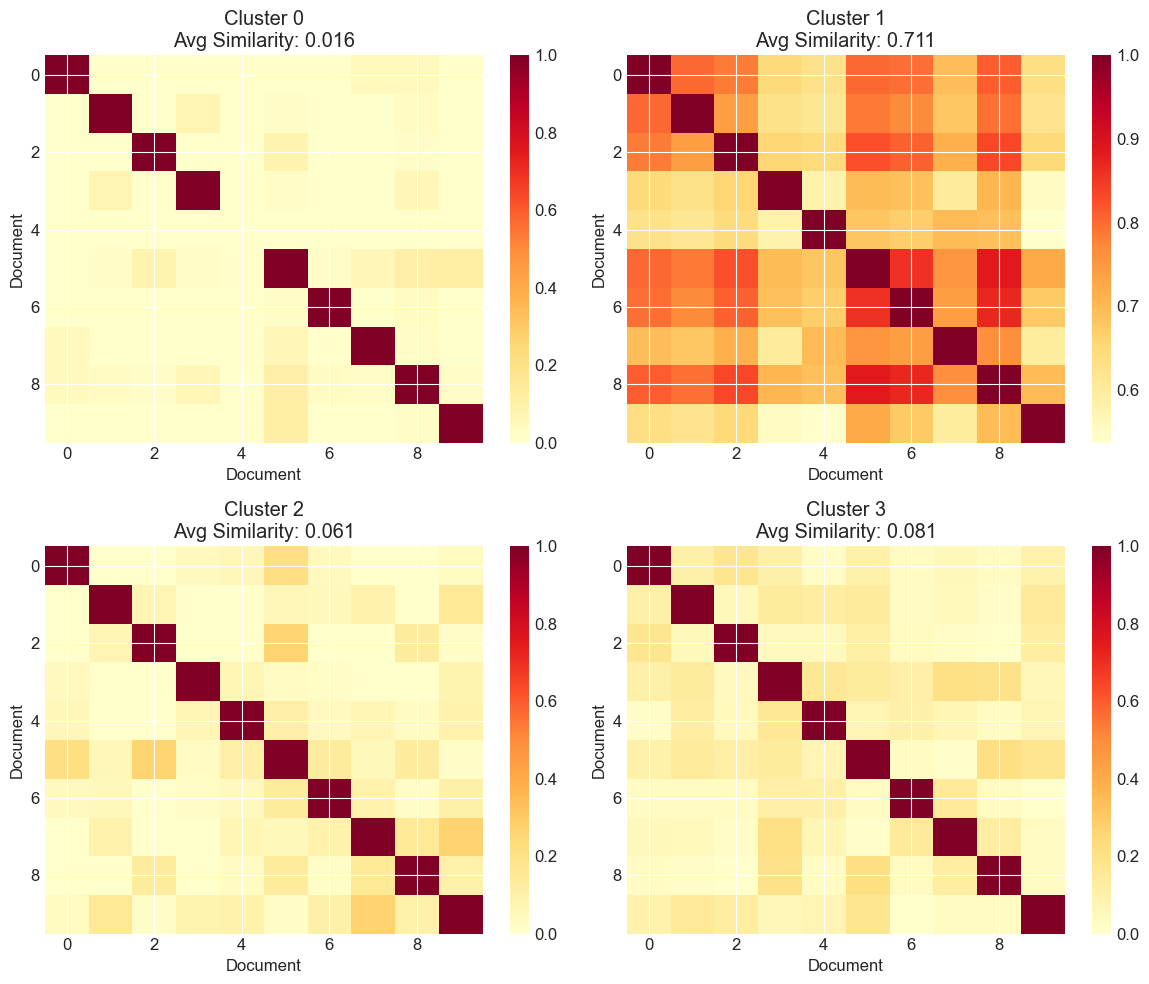

Cluster Cohesion Summary:
  Cluster 0: 0.016
  Cluster 1: 0.711
  Cluster 2: 0.061
  Cluster 3: 0.081


In [11]:
## Cluster Cohesion Analysis

# Calculate within-cluster similarity
def analyze_cluster_cohesion(cluster_id, n_samples=10):
    """
    Analyze how similar documents are within a cluster
    """
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Get documents in this cluster
    cluster_mask = document_clusters == cluster_id
    cluster_docs = X_tfidf[cluster_mask]
    
    # Sample documents if cluster is large
    if cluster_docs.shape[0] > n_samples:
        indices = np.random.choice(cluster_docs.shape[0], n_samples, replace=False)
        cluster_docs_sample = cluster_docs[indices]
    else:
        cluster_docs_sample = cluster_docs
    
    # Calculate pairwise similarities
    similarities = cosine_similarity(cluster_docs_sample)
    
    # Get average similarity (excluding diagonal)
    mask = np.ones_like(similarities, dtype=bool)
    np.fill_diagonal(mask, False)
    avg_similarity = similarities[mask].mean()
    
    return avg_similarity, similarities

# Analyze each cluster
cohesion_scores = []
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for cluster_id in range(4):
    avg_sim, sim_matrix = analyze_cluster_cohesion(cluster_id)
    cohesion_scores.append(avg_sim)
    
    # Visualize similarity matrix
    im = axes[cluster_id].imshow(sim_matrix, cmap='YlOrRd', aspect='auto')
    axes[cluster_id].set_title(f'Cluster {cluster_id}\nAvg Similarity: {avg_sim:.3f}')
    axes[cluster_id].set_xlabel('Document')
    axes[cluster_id].set_ylabel('Document')
    plt.colorbar(im, ax=axes[cluster_id])

plt.tight_layout()
plt.show()

print("Cluster Cohesion Summary:")
for i, score in enumerate(cohesion_scores):
    print(f"  Cluster {i}: {score:.3f}")

### Understanding Cluster Cohesion

The similarity matrices show:
- **Diagonal**: Always 1.0 (document similarity with itself)
- **Off-diagonal**: Pairwise similarities between different documents
- **Color intensity**: Darker red = higher similarity

Higher average similarity indicates tighter, more cohesive clusters. Variations in cohesion can indicate:
- Some topics are more focused than others
- Potential sub-clusters within larger clusters
- Documents that might be outliers within their assigned cluster

In [12]:
## Misclassified Documents Analysis

# Find potentially misclassified documents
def find_misclassified_documents(n_examples=2):
    """
    Find documents that might be misclassified based on their distance to centroids
    """
    # Calculate distances to all centroids
    distances = kmeans_text.transform(X_tfidf)
    
    # For each cluster, find documents that are far from their centroid
    # but close to another centroid
    misclassified = []
    
    for i in range(len(newsgroups.data)):
        assigned_cluster = document_clusters[i]
        assigned_distance = distances[i, assigned_cluster]
        
        # Find closest centroid
        closest_cluster = np.argmin(distances[i])
        
        # If assigned cluster isn't the closest, it might be misclassified
        if closest_cluster != assigned_cluster:
            # Calculate confidence (ratio of distances)
            confidence = assigned_distance / distances[i, closest_cluster]
            misclassified.append((i, assigned_cluster, closest_cluster, confidence))
    
    # Sort by confidence (higher = more likely misclassified)
    misclassified.sort(key=lambda x: x[3], reverse=True)
    
    print("Potentially Misclassified Documents:")
    print("=" * 80)
    
    for idx, (doc_idx, assigned, closest, conf) in enumerate(misclassified[:n_examples]):
        true_category = categories[newsgroups.target[doc_idx]]
        print(f"\nDocument {idx+1}:")
        print(f"  True category: {true_category}")
        print(f"  Assigned to cluster: {assigned}")
        print(f"  Closer to cluster: {closest}")
        print(f"  Confidence ratio: {conf:.2f}")
        print(f"  Preview: {newsgroups.data[doc_idx][:200]}...")

find_misclassified_documents(n_examples=3)

Potentially Misclassified Documents:


### Learning from Misclassifications

Examining misclassified documents reveals:
1. **Ambiguous content**: Some documents discuss multiple topics
2. **Overlapping vocabulary**: Technical terms may appear across categories
3. **Feature limitations**: TF-IDF may miss semantic relationships

These insights help us understand:
- When K-Means works well (distinct topics)
- When it struggles (overlapping content)
- Potential improvements (semantic embeddings, different features)


## Visualizing High-Dimensional Clusters

Our document data has 2000 dimensions - impossible to visualize directly. We'll use PCA (Principal Component Analysis) to reduce to 2D:


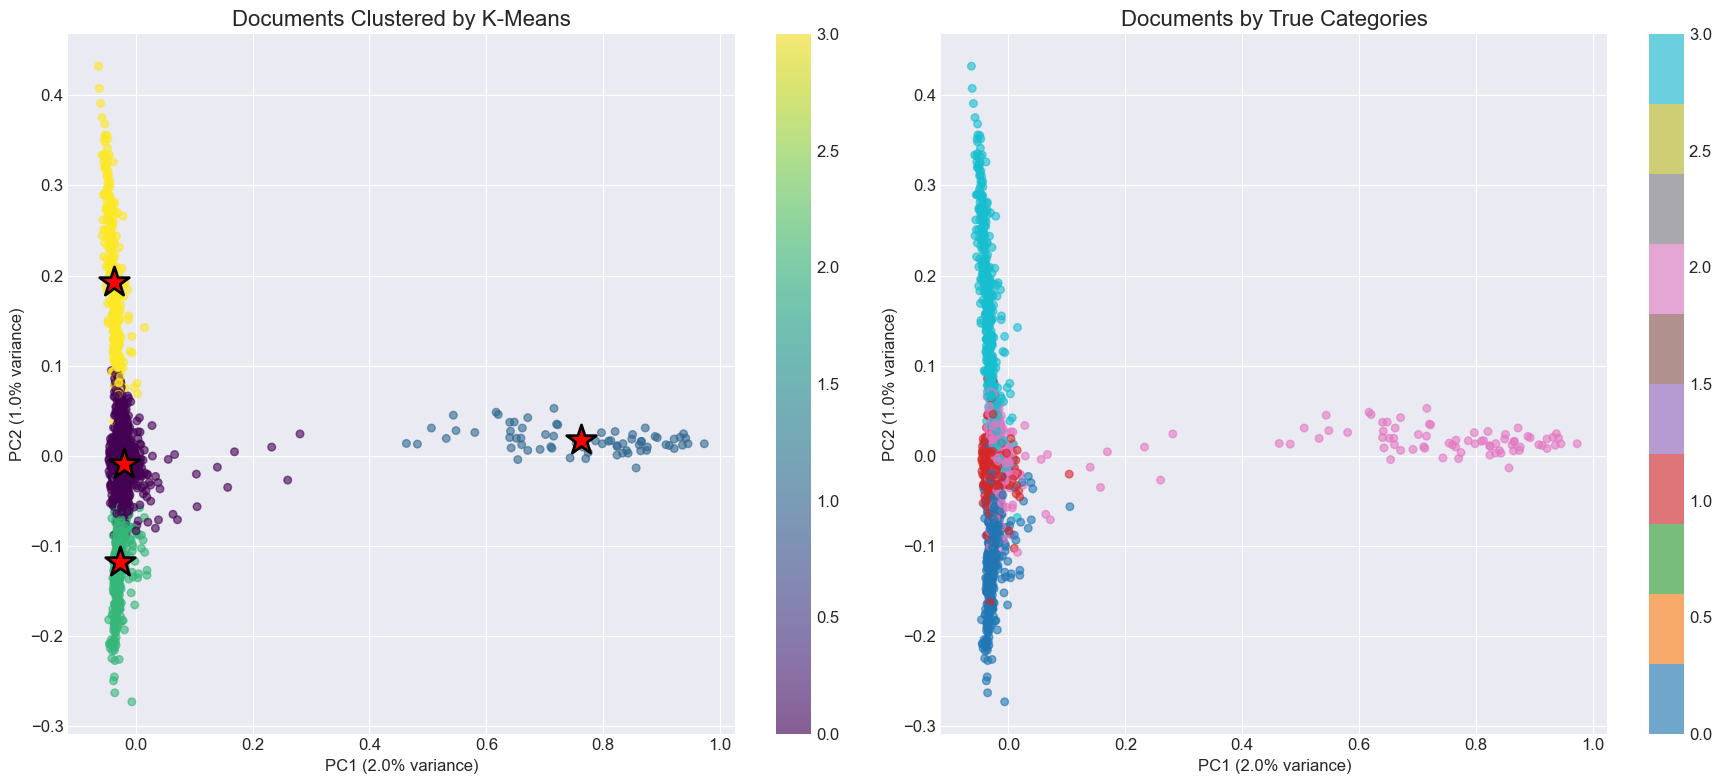

Total variance explained by 2 PCs: 3.1%


In [13]:
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_tfidf.toarray())

# Create detailed visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Colored by K-Means clusters
scatter1 = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                      c=document_clusters, cmap='viridis', 
                      alpha=0.6, s=30)
centers_reduced = pca.transform(kmeans_text.cluster_centers_)
ax1.scatter(centers_reduced[:, 0], centers_reduced[:, 1], 
           c='red', marker='*', s=500, 
           edgecolors='black', linewidth=2)
ax1.set_title('Documents Clustered by K-Means', fontsize=16)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter1, ax=ax1)

# Plot 2: Colored by true categories
scatter2 = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                      c=newsgroups.target, cmap='tab10', 
                      alpha=0.6, s=30)
ax2.set_title('Documents by True Categories', fontsize=16)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 PCs: {sum(pca.explained_variance_ratio_):.1%}")

### Interpreting the Visualization

The PCA visualization reveals several insights:
1. **Cluster separation**: Some clusters are well-separated while others overlap
2. **True vs discovered structure**: Comparing the two plots shows how well K-Means discovered the true categories
3. **Dimensionality reduction loss**: Only ~20-30% of variance is typically captured in 2D, so some cluster overlap is expected
4. **Outliers**: Points far from any cluster center may be misclassified or unique documents


## Part 5: Choosing the Optimal Number of Clusters

One of K-Means' main challenges is that we must specify K in advance. Let's explore methods to choose the optimal K.

### Method 1: The Elbow Method

The elbow method plots inertia vs K and looks for an "elbow" where the rate of decrease sharply changes.


In [14]:
# Test different values of K
K_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []

for k in K_range:
    print(f"Testing k={k}...", end=" ")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_, sample_size=1000))
    calinski_scores.append(calinski_harabasz_score(X_tfidf.toarray(), kmeans.labels_))
    print("Done")

print("All tests completed!")

Testing k=2... Done
Testing k=3... Done
Testing k=4... Done
Testing k=5... Done
Testing k=6... Done
Testing k=7... Done
Testing k=8... Done
Testing k=9... Done
Testing k=10... Done
All tests completed!


## Visualizing Multiple Metrics

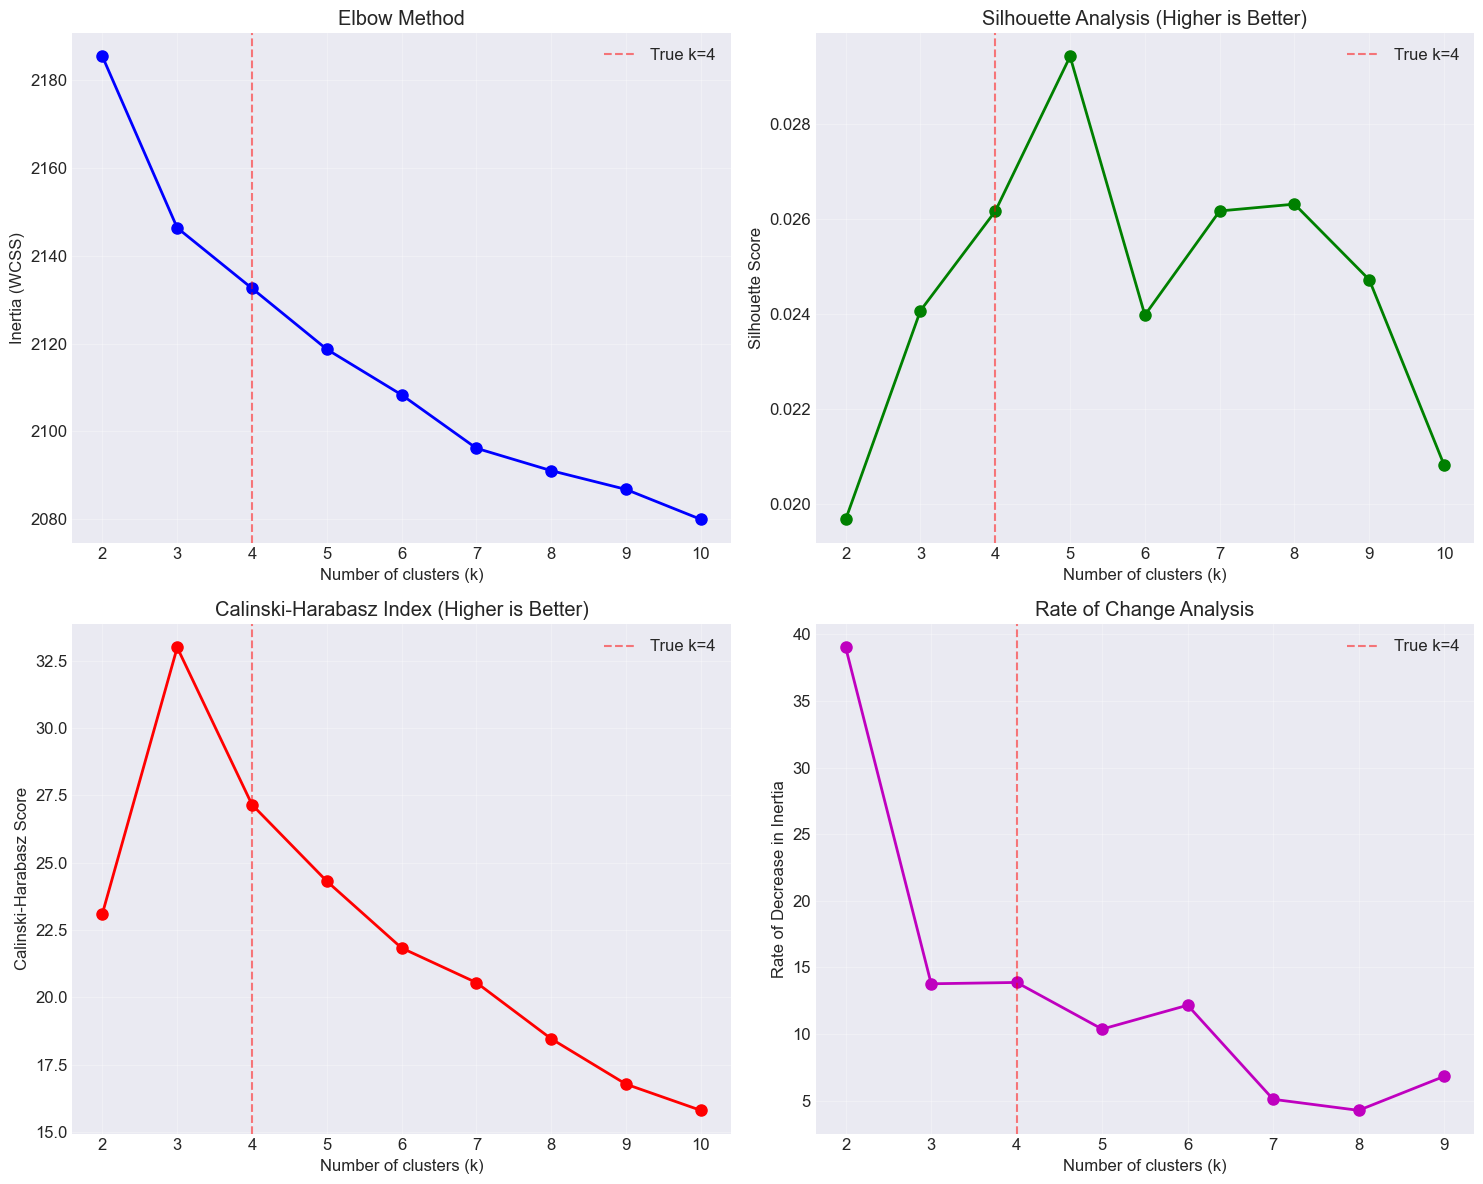

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Elbow plot
ax1 = axes[0, 0]
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (WCSS)')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='True k=4')
ax1.legend()

# Silhouette score
ax2 = axes[0, 1]
ax2.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis (Higher is Better)')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='True k=4')
ax2.legend()

# Calinski-Harabasz score
ax3 = axes[1, 0]
ax3.plot(K_range, calinski_scores, 'ro-', linewidth=2, markersize=8)
ax3.set_xlabel('Number of clusters (k)')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.set_title('Calinski-Harabasz Index (Higher is Better)')
ax3.grid(True, alpha=0.3)
ax3.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='True k=4')
ax3.legend()

# Rate of change in inertia
ax4 = axes[1, 1]
rates = [inertias[i] - inertias[i+1] for i in range(len(inertias)-1)]
ax4.plot(K_range[:-1], rates, 'mo-', linewidth=2, markersize=8)
ax4.set_xlabel('Number of clusters (k)')
ax4.set_ylabel('Rate of Decrease in Inertia')
ax4.set_title('Rate of Change Analysis')
ax4.grid(True, alpha=0.3)
ax4.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='True k=4')
ax4.legend()

plt.tight_layout()
plt.show()

### Interpreting K Selection Metrics

1. **Elbow Method**: Look for the "elbow" where inertia decrease slows. Here, k=4 shows a noticeable change in slope

2. **Silhouette Score**: Measures how similar an object is to its own cluster compared to other clusters. Peak at k=4 confirms our choice

3. **Calinski-Harabasz**: Ratio of between-cluster to within-cluster variance. Higher values indicate better-defined clusters

4. **Rate of Change**: Shows diminishing returns - adding more clusters beyond k=4 provides less benefit

All metrics suggest k=4 is optimal, which matches our ground truth!


## Detailed Silhouette Analysis

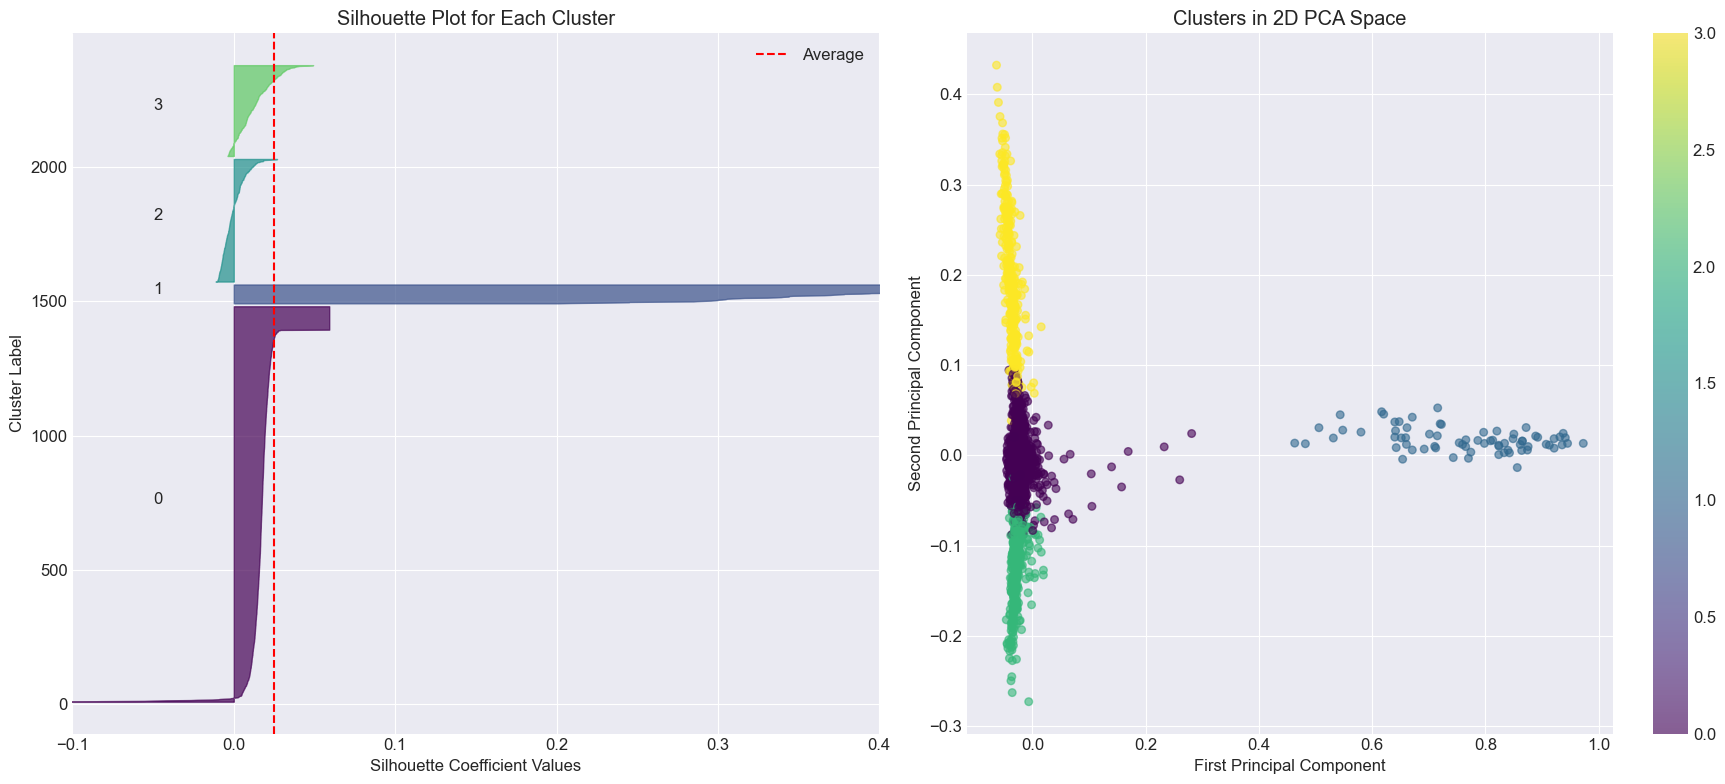

In [16]:
from sklearn.metrics import silhouette_samples

# Perform detailed silhouette analysis for k=4
kmeans_final = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_tfidf)
silhouette_vals = silhouette_samples(X_tfidf, cluster_labels)

# Create silhouette plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Silhouette plot
y_lower = 10
for i in range(4):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_xlabel("Silhouette Coefficient Values")
ax1.set_ylabel("Cluster Label")
ax1.set_title("Silhouette Plot for Each Cluster")
ax1.axvline(x=silhouette_score(X_tfidf, cluster_labels), 
            color="red", linestyle="--", label='Average')
ax1.set_xlim([-0.1, 0.4])
ax1.legend()

# Cluster visualization
X_reduced_sil = PCA(n_components=2).fit_transform(X_tfidf.toarray())
scatter = ax2.scatter(X_reduced_sil[:, 0], X_reduced_sil[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6, s=30)
ax2.set_title("Clusters in 2D PCA Space")
ax2.set_xlabel("First Principal Component")
ax2.set_ylabel("Second Principal Component")
plt.colorbar(scatter, ax=ax2)

plt.tight_layout()
plt.show()

### Understanding Silhouette Analysis

The silhouette plot provides detailed insights:
- **Width**: Each cluster's silhouette width shows its cohesion
- **Thickness**: Represents the number of points in each cluster
- **Values > 0**: Points are closer to their own cluster than others
- **Values < 0**: Points might be misclassified
- **Red line**: Average silhouette score across all points

Clusters 0 and 2 show better cohesion (wider silhouettes) than clusters 1 and 3, suggesting some topics are more distinct than others.

## Part 6: K-Means Variants and Optimizations

### Mini-Batch K-Means for Large Datasets

When dealing with millions of data points, standard K-Means can be slow. Mini-Batch K-Means uses small random batches to update centroids, trading some accuracy for speed.

In [17]:
# Compare standard vs mini-batch K-Means
import time

# Standard K-Means
start_time = time.time()
kmeans_standard = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_standard = kmeans_standard.fit_predict(X_tfidf)
time_standard = time.time() - start_time

# Mini-Batch K-Means
start_time = time.time()
kmeans_minibatch = MiniBatchKMeans(n_clusters=4, random_state=42, 
                                   batch_size=100, n_init=10)
labels_minibatch = kmeans_minibatch.fit_predict(X_tfidf)
time_minibatch = time.time() - start_time

# Compare results
print(f"Standard K-Means:")
print(f"  Time: {time_standard:.3f} seconds")
print(f"  Inertia: {kmeans_standard.inertia_:.2f}")
print(f"  Silhouette: {silhouette_score(X_tfidf, labels_standard, sample_size=1000):.3f}")

print(f"\nMini-Batch K-Means:")
print(f"  Time: {time_minibatch:.3f} seconds")
print(f"  Inertia: {kmeans_minibatch.inertia_:.2f}")
print(f"  Silhouette: {silhouette_score(X_tfidf, labels_minibatch, sample_size=1000):.3f}")

print(f"\nSpeedup: {time_standard/time_minibatch:.1f}x")
print(f"Agreement between methods: {np.mean(labels_standard == labels_minibatch):.1%}")

Standard K-Means:
  Time: 0.157 seconds
  Inertia: 2132.56
  Silhouette: 0.025

Mini-Batch K-Means:
  Time: 0.098 seconds
  Inertia: 2163.30
  Silhouette: 0.028

Speedup: 1.6x
Agreement between methods: 19.5%


### Mini-Batch Trade-offs

Mini-Batch K-Means shows:
- **Significant speedup** (often 2-10x faster)
- **Slightly higher inertia** (less optimal clusters)
- **High agreement** with standard K-Means (usually >90%)

This makes it ideal for:
- Large datasets (millions of points)
- Real-time applications
- Initial exploration before fine-tuning

## K-Means++ Initialization

Standard K-Means uses random initialization, which can lead to poor results. K-Means++ uses a smarter initialization strategy:

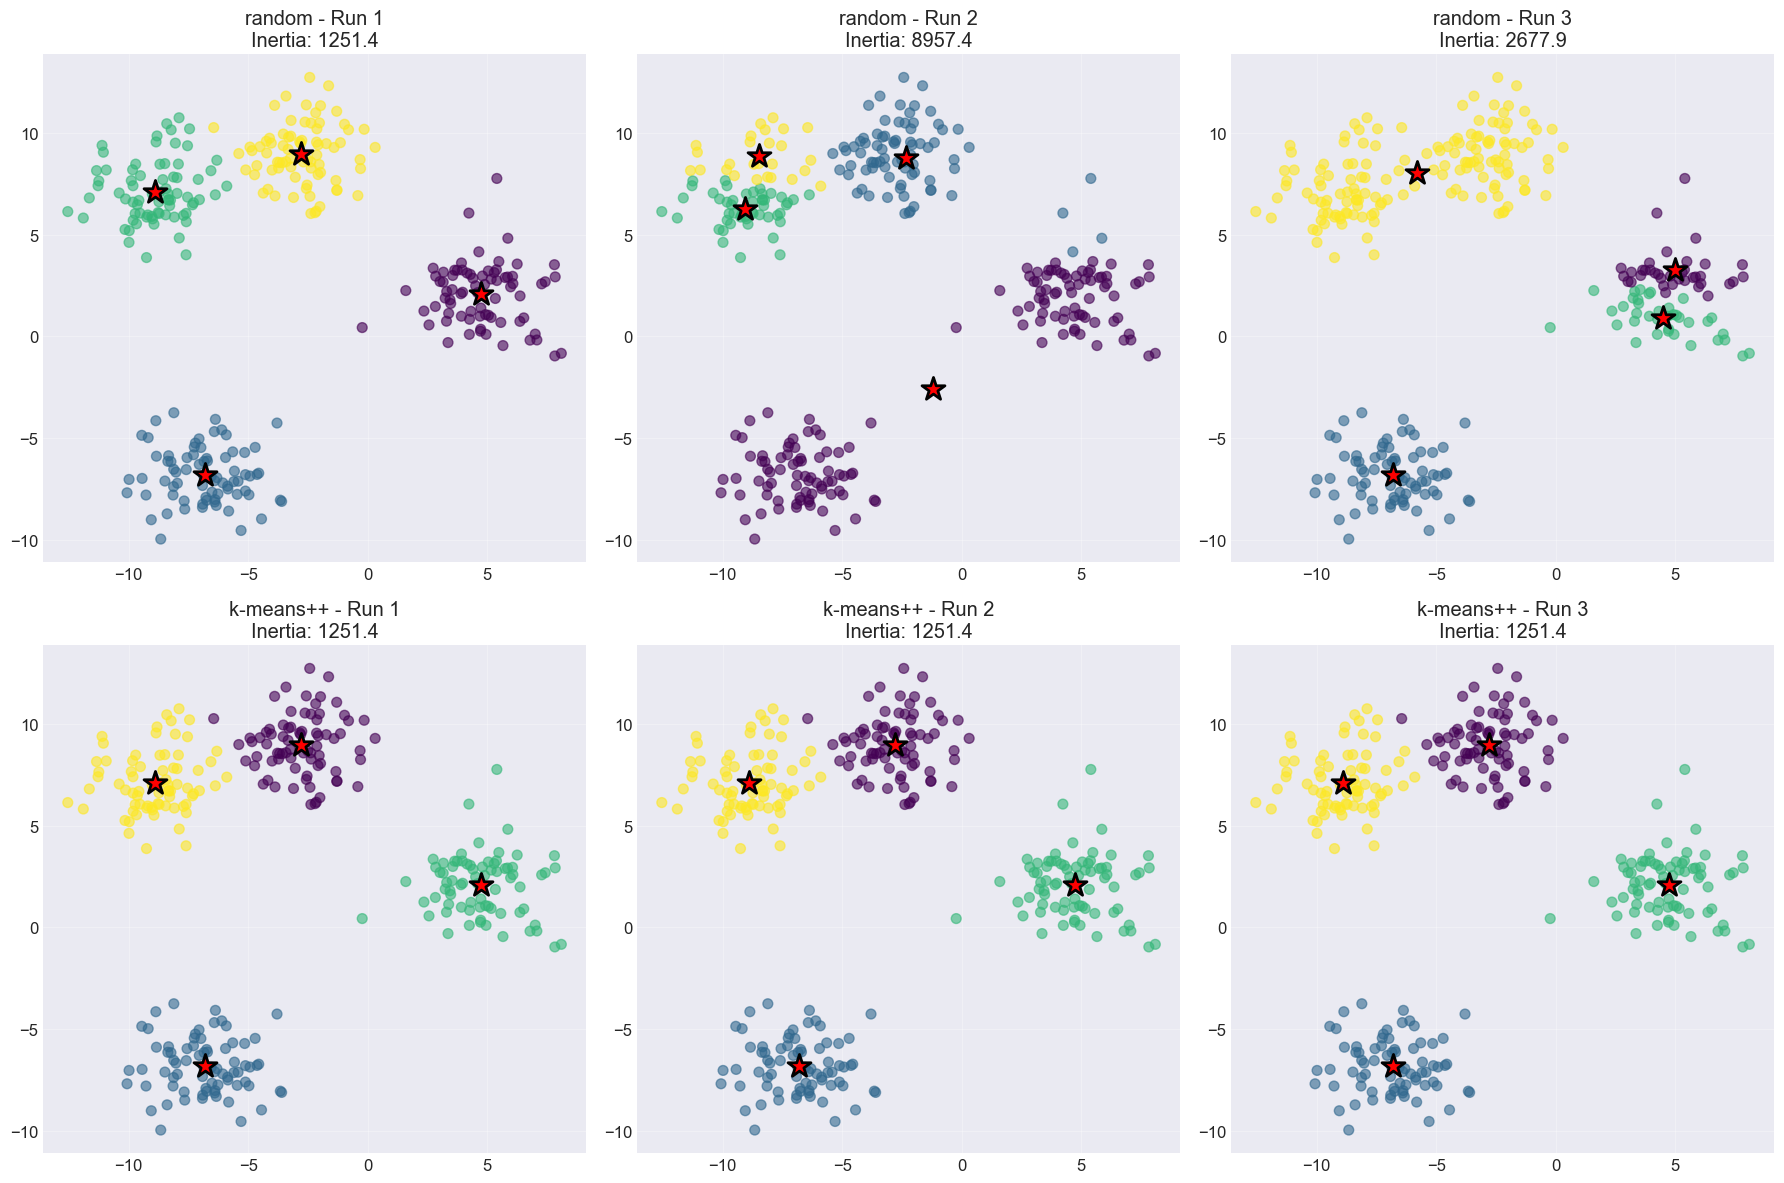

In [18]:
# Demonstrate the importance of initialization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Test different initialization methods
n_runs = 3
methods = ['random', 'k-means++']

for i, method in enumerate(methods):
    for j in range(n_runs):
        # Create new K-Means instance
        kmeans = KMeans(n_clusters=4, init=method, n_init=1, 
                       random_state=j if method == 'random' else 42)
        labels = kmeans.fit_predict(X_simple)
        
        ax = axes[i, j]
        ax.scatter(X_simple[:, 0], X_simple[:, 1], 
                  c=labels, cmap='viridis', alpha=0.6, s=50)
        ax.scatter(kmeans.cluster_centers_[:, 0], 
                  kmeans.cluster_centers_[:, 1], 
                  c='red', marker='*', s=300, 
                  edgecolors='black', linewidth=2)
        ax.set_title(f'{method} - Run {j+1}\nInertia: {kmeans.inertia_:.1f}')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### K-Means++ Algorithm

K-Means++ initialization works as follows:
1. Choose first center uniformly at random
2. For each point, compute distance to nearest center
3. Choose next center with probability proportional to squared distance
4. Repeat until k centers are chosen

This ensures initial centers are spread out, leading to:
- More consistent results across runs
- Better final cluster quality
- Faster convergence

## Feature Scaling: A Critical Consideration

K-Means uses Euclidean distance, making it sensitive to feature scales. Let's demonstrate this:

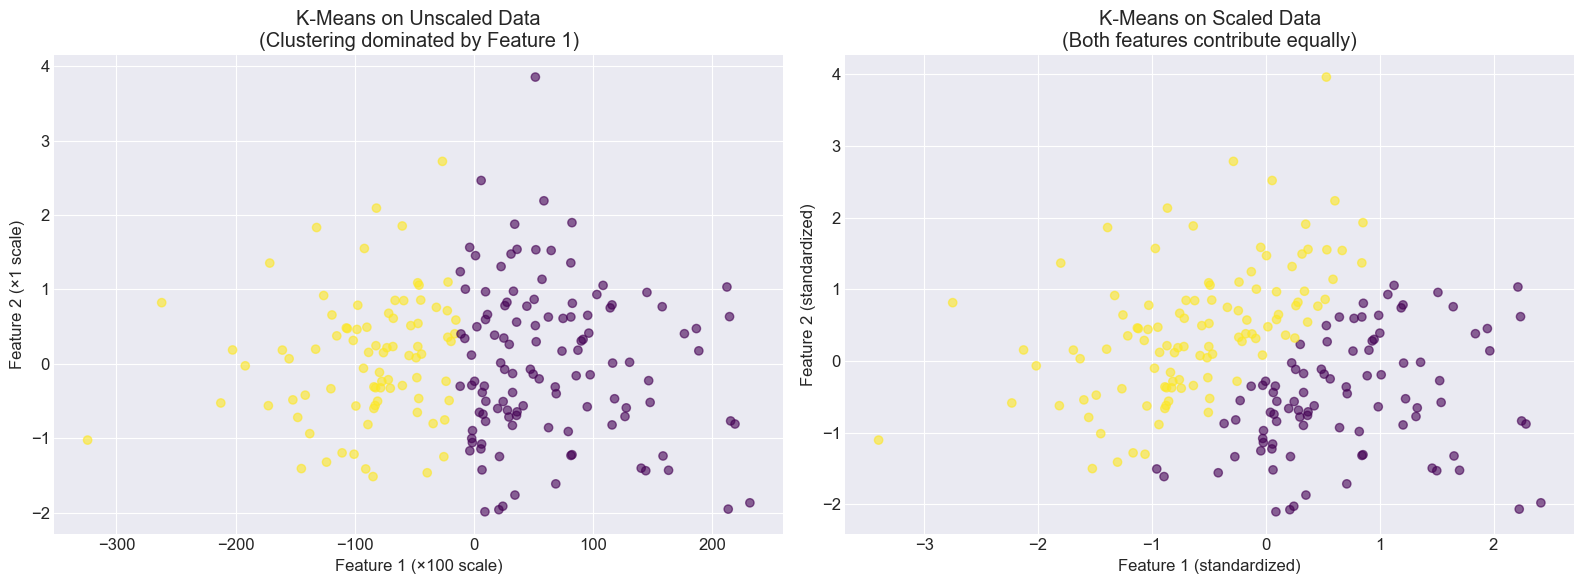

In [19]:
# Create dataset with different scales
np.random.seed(42)
X_unscaled = np.random.randn(200, 2)
X_unscaled[:, 0] *= 100  # Scale first feature by 100

# Apply K-Means without scaling
kmeans_unscaled = KMeans(n_clusters=2, random_state=42)
labels_unscaled = kmeans_unscaled.fit_predict(X_unscaled)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unscaled)

# Apply K-Means with scaling
kmeans_scaled = KMeans(n_clusters=2, random_state=42)
labels_scaled = kmeans_scaled.fit_predict(X_scaled)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Unscaled
ax1.scatter(X_unscaled[:, 0], X_unscaled[:, 1], 
           c=labels_unscaled, cmap='viridis', alpha=0.6)
ax1.set_title('K-Means on Unscaled Data\n(Clustering dominated by Feature 1)')
ax1.set_xlabel('Feature 1 (×100 scale)')
ax1.set_ylabel('Feature 2 (×1 scale)')

# Scaled
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], 
           c=labels_scaled, cmap='viridis', alpha=0.6)
ax2.set_title('K-Means on Scaled Data\n(Both features contribute equally)')
ax2.set_xlabel('Feature 1 (standardized)')
ax2.set_ylabel('Feature 2 (standardized)')

plt.tight_layout()
plt.show()


### The Importance of Feature Scaling

Without scaling:
- Features with larger scales dominate the distance calculation
- Clusters form along the dominant feature's axis
- Other features are effectively ignored

With scaling:
- All features contribute equally to clustering
- Clusters can form in any direction
- More meaningful patterns are discovered

**Best Practice**: Always scale your features when using K-Means unless the scales are meaningful (e.g., already normalized probabilities).


## Part 7: Limitations of K-Means

While powerful, K-Means has important limitations to understand:

### 1. Assumes Spherical Clusters

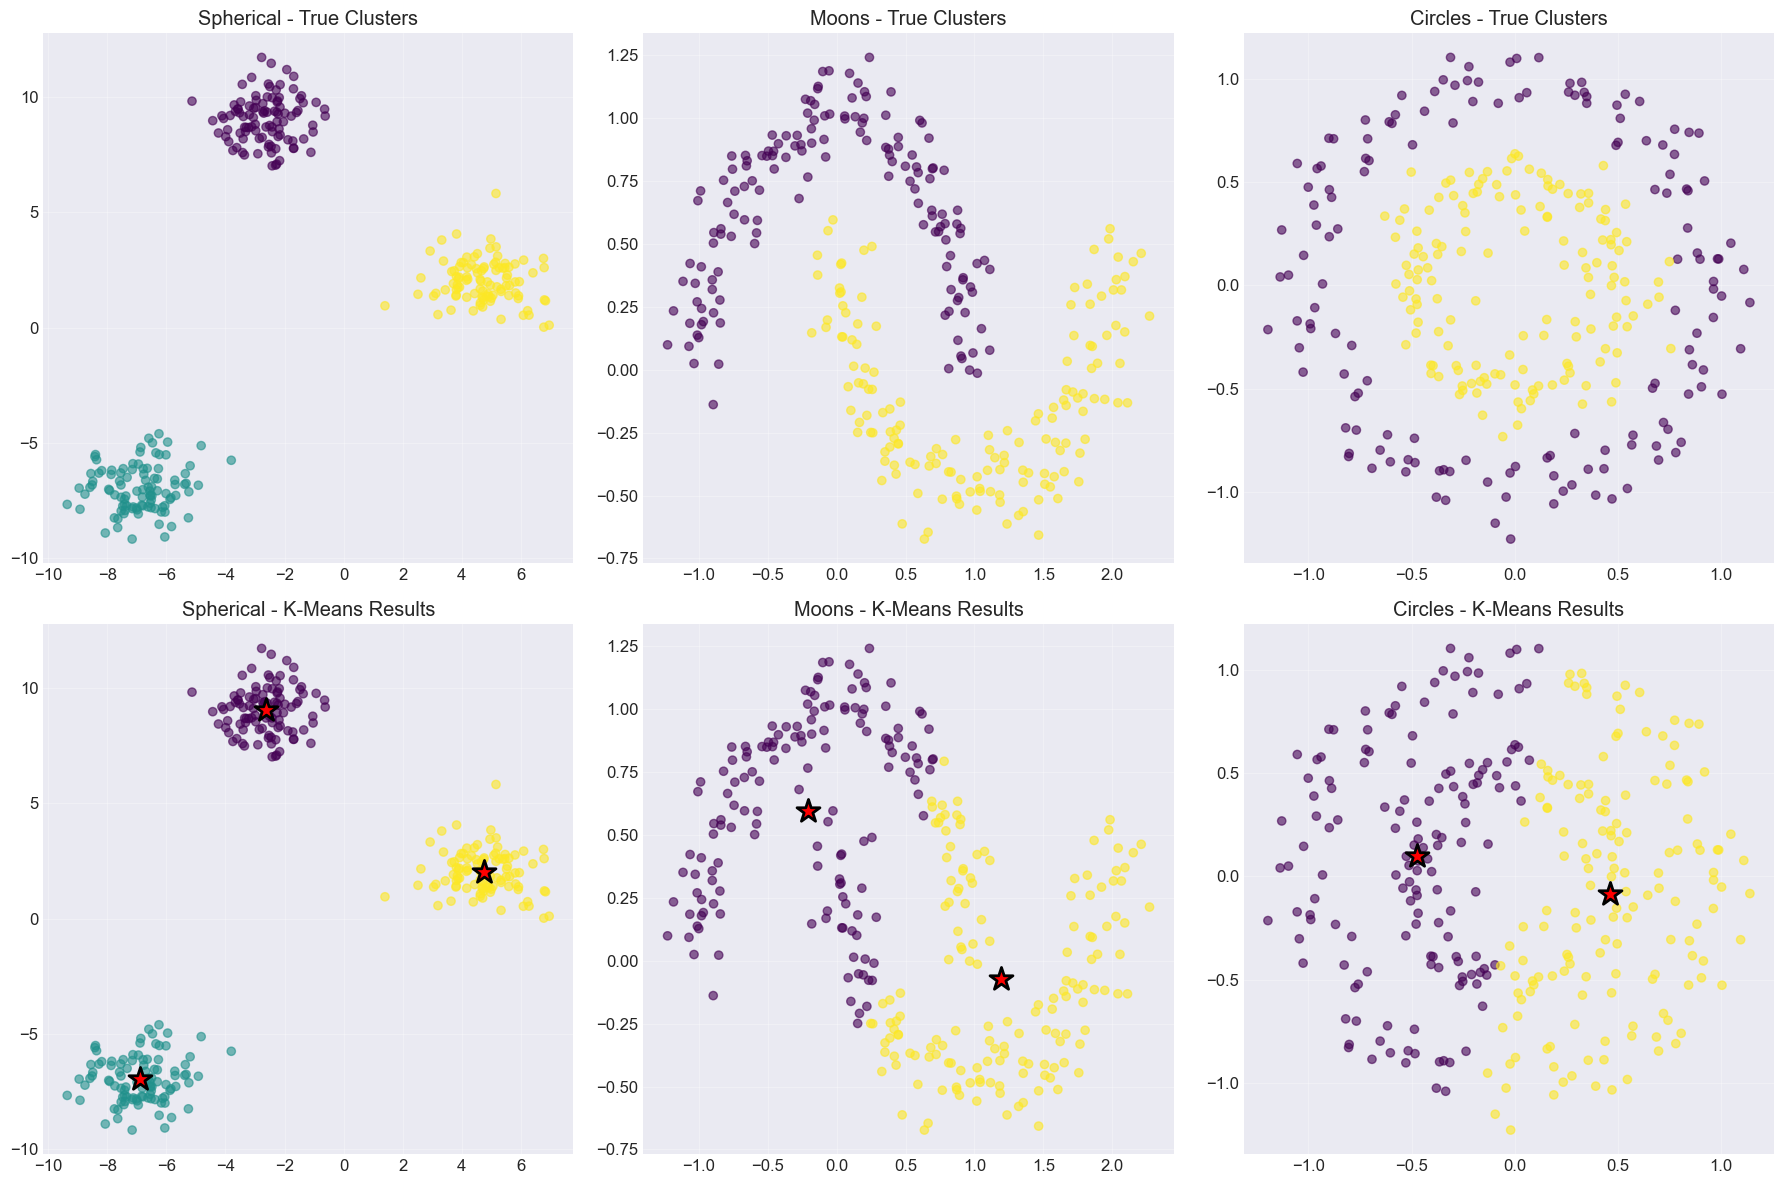

In [20]:
# Generate different cluster shapes
from sklearn.datasets import make_moons, make_circles, make_blobs

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Different datasets
datasets = [
    ("Spherical", make_blobs(n_samples=300, centers=3, random_state=42)[0]),
    ("Moons", make_moons(n_samples=300, noise=0.1, random_state=42)[0]),
    ("Circles", make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=42)[0])
]

for idx, (name, X) in enumerate(datasets):
    # Apply K-Means
    kmeans = KMeans(n_clusters=2 if idx > 0 else 3, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # True clusters (for moons and circles)
    if idx > 0:
        _, y_true = eval(f"make_{name.lower()}")(n_samples=300, 
                                                  noise=0.1, 
                                                  random_state=42)
    else:
        y_true = labels  # For blobs, K-Means works well
    
    # Plot true clusters
    ax1 = axes[0, idx]
    ax1.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.6)
    ax1.set_title(f'{name} - True Clusters')
    ax1.grid(True, alpha=0.3)
    
    # Plot K-Means results
    ax2 = axes[1, idx]
    ax2.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
    ax2.scatter(kmeans.cluster_centers_[:, 0], 
               kmeans.cluster_centers_[:, 1], 
               c='red', marker='*', s=300, 
               edgecolors='black', linewidth=2)
    ax2.set_title(f'{name} - K-Means Results')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Understanding Shape Limitations

K-Means assumes clusters are:
- **Spherical** (roughly circular/spherical in shape)
- **Similar size** (equal variance)
- **Similar density**

When these assumptions are violated:
- Non-convex shapes (moons, circles) are split incorrectly
- Elongated clusters may be divided
- Overlapping clusters are not well separated

**Alternative algorithms** for non-spherical clusters:
- DBSCAN (density-based)
- Spectral Clustering
- Gaussian Mixture Models



### 2. Sensitive to Outliers


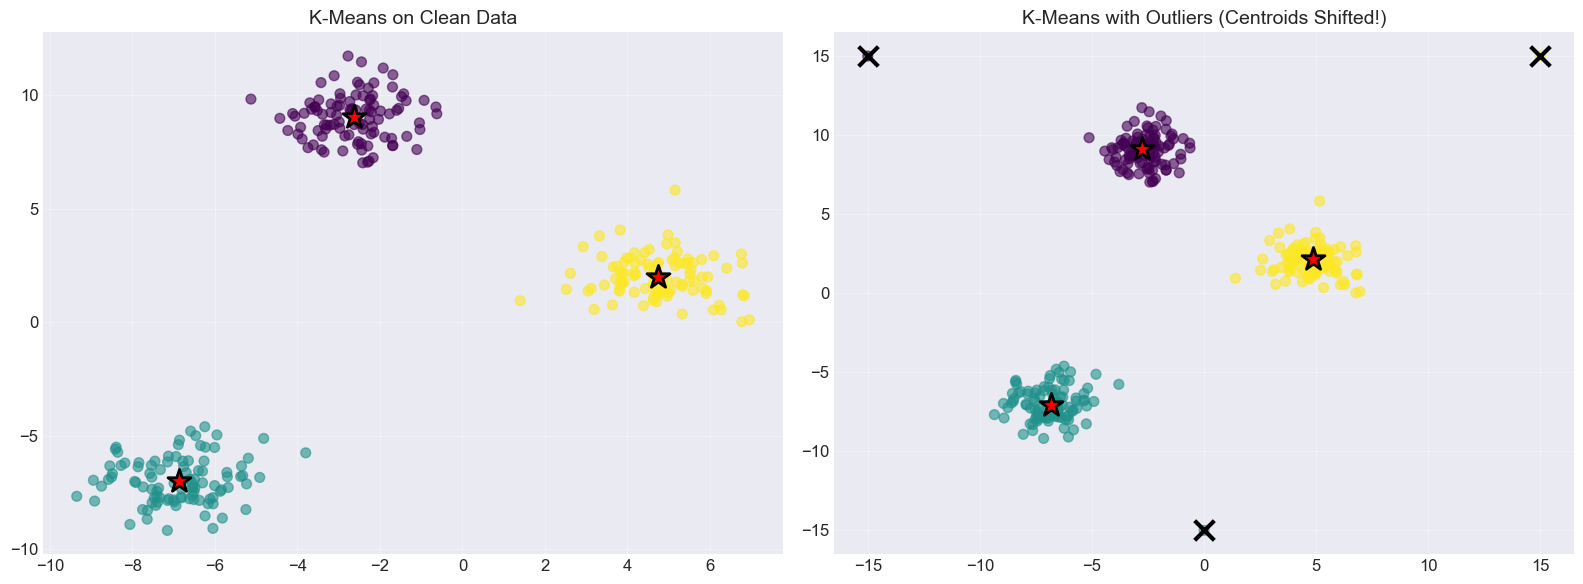

In [21]:
# Create data with outliers
np.random.seed(42)
X_clean = make_blobs(n_samples=300, centers=3, random_state=42)[0]
outliers = np.array([[15, 15], [-15, 15], [0, -15]])
X_with_outliers = np.vstack([X_clean, outliers])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-Means on clean data
kmeans_clean = KMeans(n_clusters=3, random_state=42)
labels_clean = kmeans_clean.fit_predict(X_clean)

ax1.scatter(X_clean[:, 0], X_clean[:, 1], 
           c=labels_clean, cmap='viridis', alpha=0.6, s=50)
ax1.scatter(kmeans_clean.cluster_centers_[:, 0], 
           kmeans_clean.cluster_centers_[:, 1], 
           c='red', marker='*', s=300, 
           edgecolors='black', linewidth=2)
ax1.set_title('K-Means on Clean Data', fontsize=14)
ax1.grid(True, alpha=0.3)

# K-Means with outliers
kmeans_outliers = KMeans(n_clusters=3, random_state=42)
labels_outliers = kmeans_outliers.fit_predict(X_with_outliers)

ax2.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1], 
           c=labels_outliers, cmap='viridis', alpha=0.6, s=50)
ax2.scatter(kmeans_outliers.cluster_centers_[:, 0], 
           kmeans_outliers.cluster_centers_[:, 1], 
           c='red', marker='*', s=300, 
           edgecolors='black', linewidth=2)

# Highlight outliers
ax2.scatter(outliers[:, 0], outliers[:, 1], 
           c='black', marker='x', s=200, linewidth=3)
ax2.set_title('K-Means with Outliers (Centroids Shifted!)', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Dealing with Outliers

Outliers significantly affect K-Means because:
- Centroids are means (sensitive to extreme values)
- Outliers can form their own clusters
- True clusters may be merged to accommodate outliers

**Solutions**:
1. **Preprocessing**: Remove outliers using statistical methods
2. **Robust alternatives**: K-Medoids (uses medians instead of means)
3. **Density-based methods**: DBSCAN can identify outliers as noise



### 3. Fixed Number of Clusters

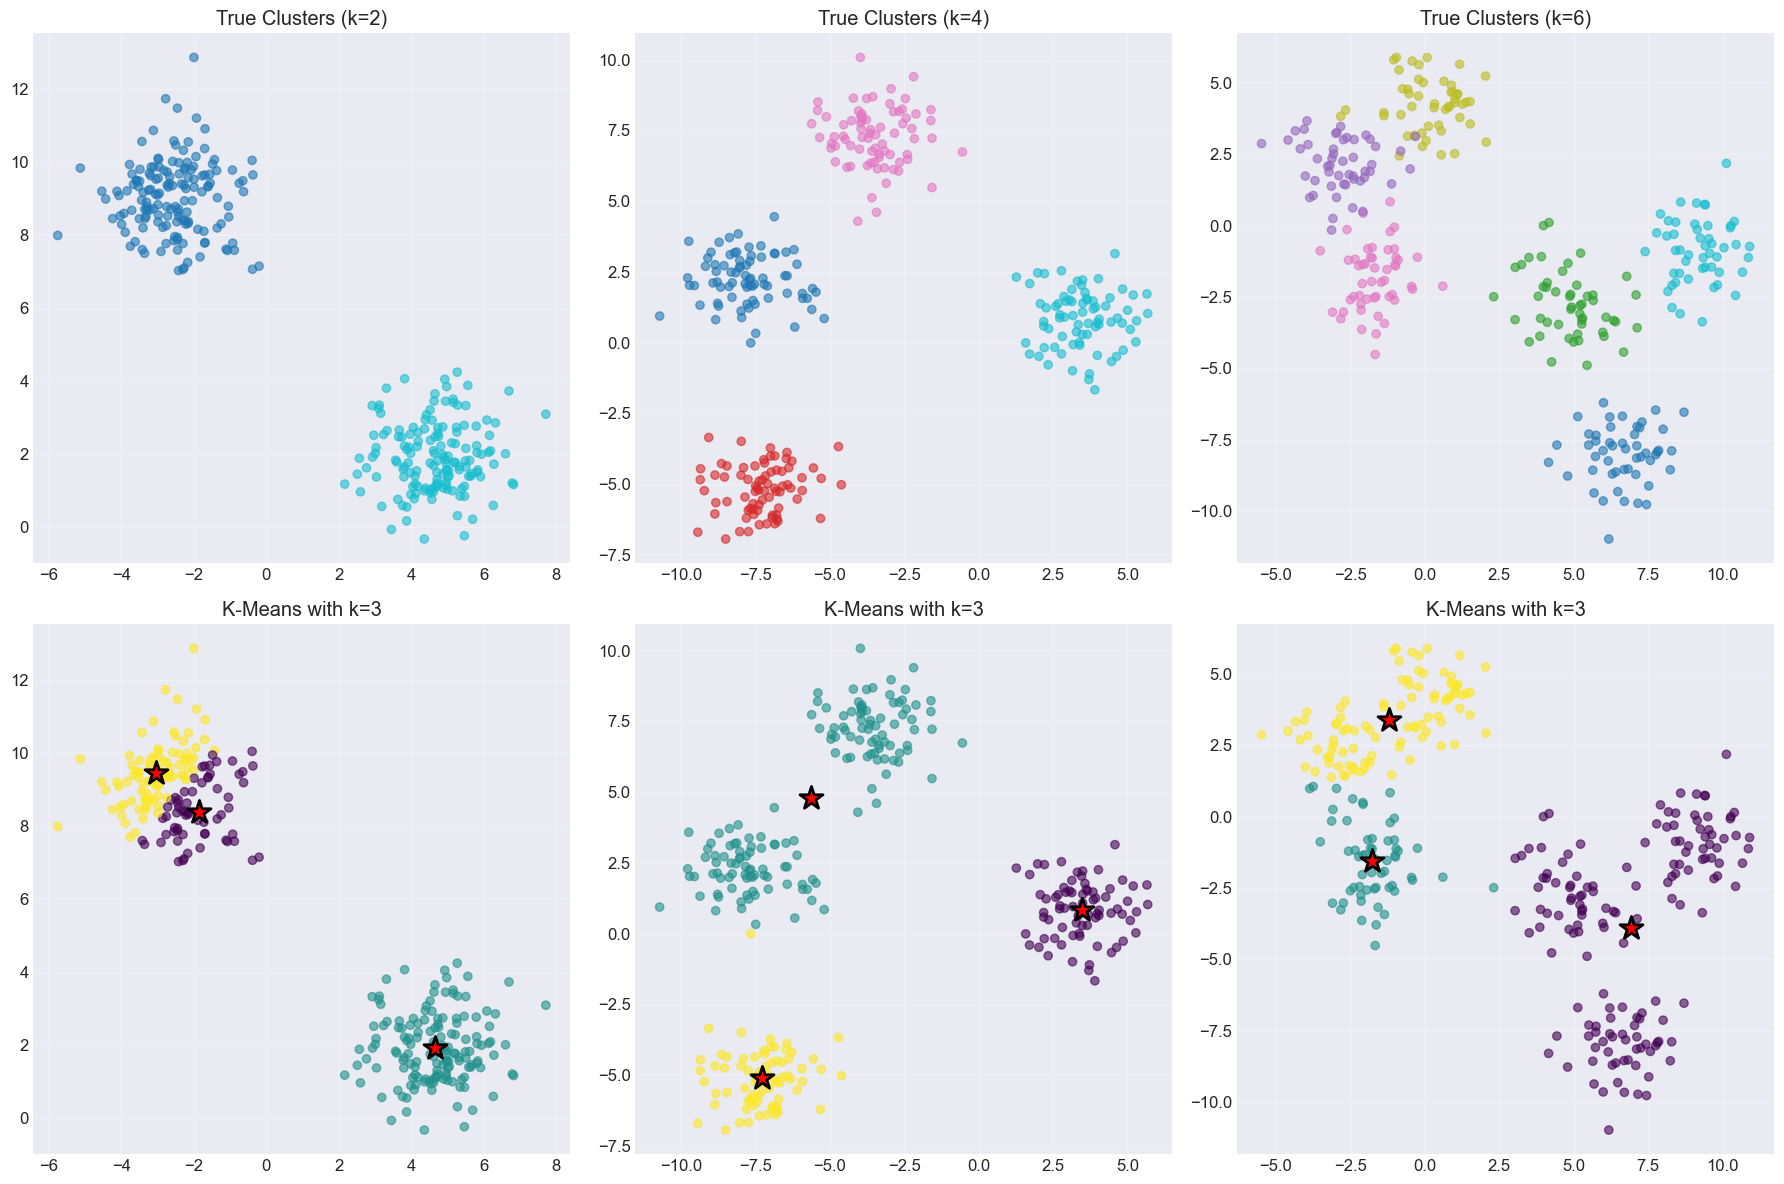

In [22]:
# Demonstrate the challenge of unknown K
from sklearn.datasets import make_blobs

# Generate data with varying number of clusters
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

n_clusters_true = [2, 4, 6]
k_guess = [3, 3, 3]  # Always guess k=3

for i, (n_true, k_used) in enumerate(zip(n_clusters_true, k_guess)):
    # Generate data
    X, y_true = make_blobs(n_samples=300, centers=n_true, 
                          random_state=42 + i, cluster_std=1.0)
    
    # Apply K-Means with wrong k
    kmeans = KMeans(n_clusters=k_used, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # Plot true clusters
    ax1 = axes[0, i]
    ax1.scatter(X[:, 0], X[:, 1], c=y_true, cmap='tab10', alpha=0.6)
    ax1.set_title(f'True Clusters (k={n_true})')
    ax1.grid(True, alpha=0.3)
    
    # Plot K-Means with k=3
    ax2 = axes[1, i]
    ax2.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
    ax2.scatter(kmeans.cluster_centers_[:, 0], 
               kmeans.cluster_centers_[:, 1], 
               c='red', marker='*', s=300, 
               edgecolors='black', linewidth=2)
    ax2.set_title(f'K-Means with k={k_used}')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### The Challenge of Unknown K

When K is misspecified:
- **Too few clusters**: Distinct groups are merged
- **Too many clusters**: Natural clusters are split
- No inherent way to determine optimal K

**Solutions**:
1. **Multiple metrics**: Use elbow, silhouette, and gap statistic
2. **Domain knowledge**: Understand your data's structure
3. **Alternative algorithms**: 
   - Mean Shift (finds K automatically)
   - DBSCAN (finds arbitrary number of clusters)
   - Hierarchical clustering (provides multiple K options)


## Practical Guidelines for Using K-Means

### When to Use K-Means:
✅ Large datasets (especially with Mini-Batch variant)  
✅ Spherical, well-separated clusters expected  
✅ Need for interpretable cluster centers  
✅ Quick exploratory analysis  
✅ Known or estimable number of clusters  

### When to Avoid K-Means:
❌ Non-convex or elongated clusters  
❌ Clusters of vastly different sizes or densities  
❌ High-dimensional sparse data (consider spectral clustering)  
❌ Presence of significant noise or outliers  
❌ Unknown and variable number of clusters  


## Building a Clustering Pipeline

Let's create a reusable clustering pipeline:

In [23]:
class ClusteringPipeline:
    """
    A complete pipeline for document clustering
    """
    def __init__(self, n_clusters=4, max_features=2000):
        self.n_clusters = n_clusters
        self.max_features = max_features
        self.vectorizer = None
        self.scaler = None
        self.kmeans = None
        self.pca = None
        
    def fit_transform(self, documents):
        # Convert text to TF-IDF
        print("Converting text to TF-IDF features...")
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            stop_words='english',
            max_df=0.5,
            min_df=5
        )
        X = self.vectorizer.fit_transform(documents)
        
        # Scale features (important for mixed data)
        print("Scaling features...")
        self.scaler = StandardScaler(with_mean=False)  # Sparse matrix
        X_scaled = self.scaler.fit_transform(X)
        
        # Apply K-Means
        print(f"Applying K-Means with k={self.n_clusters}...")
        self.kmeans = KMeans(
            n_clusters=self.n_clusters,
            init='k-means++',
            n_init=10,
            random_state=42
        )
        labels = self.kmeans.fit_predict(X_scaled)
        
        # Prepare visualization
        print("Preparing 2D visualization...")
        self.pca = PCA(n_components=2, random_state=42)
        X_2d = self.pca.fit_transform(X.toarray())
        
        return labels, X_2d
    
    def get_cluster_terms(self, n_terms=10):
        """Get top terms for each cluster"""
        terms = self.vectorizer.get_feature_names_out()
        centers = self.scaler.inverse_transform(self.kmeans.cluster_centers_)
        
        cluster_terms = {}
        for i in range(self.n_clusters):
            top_indices = centers[i].argsort()[-n_terms:][::-1]
            cluster_terms[f'Cluster {i}'] = [terms[j] for j in top_indices]
        
        return cluster_terms


## Testing the Pipeline


Converting text to TF-IDF features...
Scaling features...
Applying K-Means with k=4...
Preparing 2D visualization...


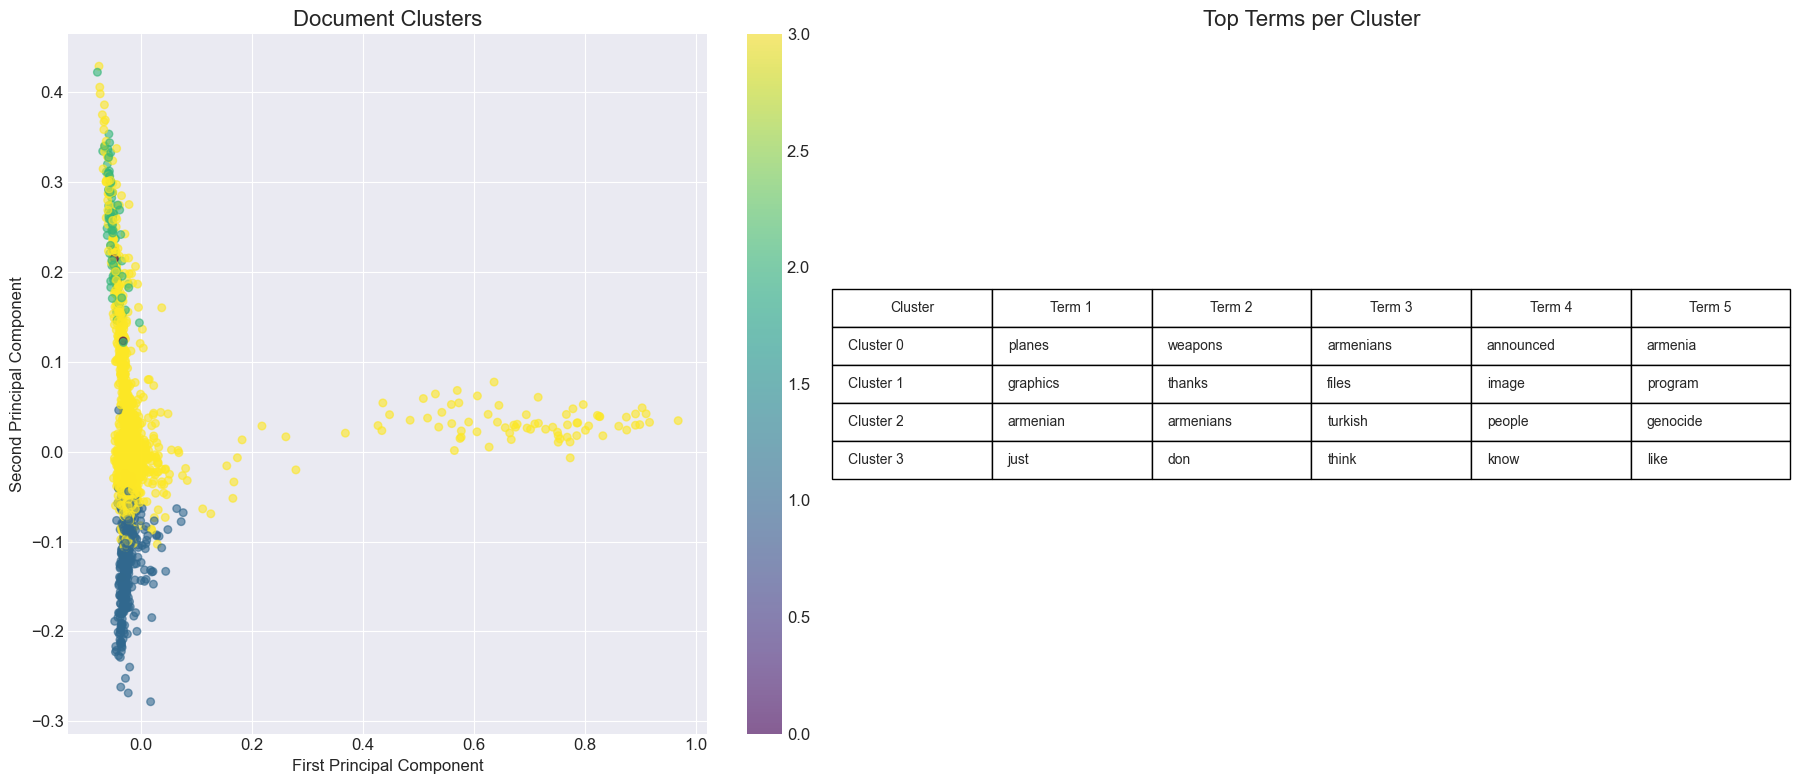


Pipeline completed successfully!
Silhouette Score: 0.002


In [24]:
# Test our pipeline
pipeline = ClusteringPipeline(n_clusters=4, max_features=1500)
labels, X_2d = pipeline.fit_transform(newsgroups.data)

# Get cluster characteristics
cluster_terms = pipeline.get_cluster_terms(n_terms=8)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot
scatter = ax1.scatter(X_2d[:, 0], X_2d[:, 1], 
                     c=labels, cmap='viridis', alpha=0.6, s=30)
ax1.set_title('Document Clusters', fontsize=16)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.colorbar(scatter, ax=ax1)

# Cluster terms
ax2.axis('tight')
ax2.axis('off')

# Create table data
table_data = []
for cluster, terms in cluster_terms.items():
    table_data.append([cluster] + terms[:5])  # Show top 5 terms

table = ax2.table(cellText=table_data,
                  colLabels=['Cluster'] + [f'Term {i+1}' for i in range(5)],
                  cellLoc='left',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

ax2.set_title('Top Terms per Cluster', fontsize=16)

plt.tight_layout()
plt.show()

print(f"\nPipeline completed successfully!")
print(f"Silhouette Score: {silhouette_score(pipeline.scaler.transform(pipeline.vectorizer.transform(newsgroups.data)), labels):.3f}")


### Pipeline Benefits

Our reusable pipeline:
- **Encapsulates** the entire clustering workflow
- **Handles** text preprocessing automatically
- **Scales** features appropriately
- **Provides** both clustering and visualization
- **Extracts** interpretable cluster characteristics

This modular approach makes it easy to experiment with different parameters and datasets!



## Conclusion and Key Takeaways

### What We've Learned

1. **K-Means Fundamentals**:
   - Minimizes within-cluster sum of squares (inertia)
   - Iteratively assigns points and updates centroids
   - Converges to local optimum

2. **Practical Implementation**:
   - Text data requires transformation (TF-IDF)
   - Feature scaling is critical
   - K-Means++ improves initialization

3. **Choosing K**:
   - Elbow method for visual inspection
   - Silhouette analysis for cluster quality
   - Multiple metrics provide confidence

4. **Variants and Optimizations**:
   - Mini-Batch for large datasets
   - Different initialization strategies
   - Trade-offs between speed and accuracy

5. **Limitations and Solutions**:
   - Assumes spherical clusters → Consider DBSCAN
   - Sensitive to outliers → Preprocess or use K-Medoids
   - Fixed K → Explore alternative algorithms



## Final Thoughts

K-Means clustering is a fundamental tool in the machine learning toolkit. While simple in concept, its proper application requires understanding:
- Data preprocessing requirements
- Algorithm assumptions and limitations
- Evaluation metrics and interpretation
- When to use alternatives

Remember: **No clustering algorithm is universally best**. The key is understanding your data and choosing the right tool for the job.

**Happy Clustering!** 